In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
current_path = os.getcwd()
parent_directory = os.path.dirname(current_path)
sys.path.append(parent_directory)
from Class.jenie import Jenie
import pandas as pd
import numpy as np
import scanpy as sc
import anndata
import umap.umap_ as umap
import leidenalg
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.cluster import KMeans
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import pairwise_distances
from scipy.stats import zscore
from matplotlib.colorbar import ColorbarBase
import matplotlib.colors as mcolors
from umap import UMAP
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score
from kneed import KneeLocator
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ParameterGrid

In [3]:
import doctest
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.datasets import make_blobs
from scipy.stats import multivariate_normal
from matplotlib.patches import Ellipse
from sklearn.neighbors import NearestNeighbors
import scanpy as sc
#from geopy.distance import geodesic
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
import umap.umap_ as umap
#from umap import UMAP
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
#from leidenalg import find_partition
#import networkx as nx

# two useful data viz libraries
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.cluster as cluster
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.mixture import GaussianMixture
from sklearn.cluster import SpectralClustering
from kneed import KneeLocator
from sklearn.model_selection import ParameterGrid
from sklearn.cluster import DBSCAN
#import hdbscan
#from sklearn.cluster import HDBSCAN
# setup plotting in a notebook in a reasonable way
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [4]:
plt.style.use('dark_background')

### Load all data

In [5]:
xenium_scdata = sc.read_h5ad(r"D:\SMI-0214_DonCleveland_UCSD\SMI-0214_DonCleveland_UCSD\Xenium_mouse_filtered.h5ad")
xenium_scdata

AnnData object with n_obs × n_vars = 547139 × 248
    obs: 'cell_id', 'Sample ID', 'Number of genes', 'Number of transcripts', 'leiden', 'cluster_names', 'celltype'
    uns: 'Sample ID_colors', 'cell_id_colors', 'celltype_colors', 'cluster_names_colors', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_raw', 'X_spatial', 'X_spatial_rescaled', 'X_spatial_rescaled_flipped', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [6]:
cosmx_scdata = sc.read_h5ad(r"D:\SMI-0214_DonCleveland_UCSD\SMI-0214_DonCleveland_UCSD\Cosmx_mouse_filtered.h5ad")
cosmx_scdata

AnnData object with n_obs × n_vars = 132721 × 950
    obs: 'total_counts', 'leiden', 'celltype'
    var: 'mean', 'std'
    uns: 'celltype_colors', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_raw', 'X_spatial', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [7]:
gellyfish_scdata = sc.read_h5ad(r"D:\SMI-0214_DonCleveland_UCSD\SMI-0214_DonCleveland_UCSD\gellyfish_scdata.h5ad")
gellyfish_scdata

C:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 209977 × 223
    obs: 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'leiden', 'Experiment', 'Age', 'Mouse', 'Section', 'Treatment', 'MERFISH celltype', 'celltype', 'x'
    uns: 'celltype_colors', 'leiden', 'leiden_colors', 'neighbors', 'x_colors'
    obsm: 'X_pca', 'X_spatial', 'X_umap'
    obsp: 'connectivities', 'distances'

### Create overlap gene list

In [10]:
var_names = xenium_scdata.var_names.intersection(cosmx_scdata.var_names).intersection(gellyfish_scdata.var_names)
var_names

Index(['Acta2', 'Aqp4', 'Bdnf', 'Calb1', 'Cldn5', 'Fos', 'Gad1', 'Gfap',
       'Gpr17', 'Npy2r', 'Pdgfra', 'Slit2', 'Vip'],
      dtype='object')

### Xenium preprocessing

In [30]:
xenium_overlap_scdata = xenium_scdata
xenium_overlap_scdata.X = xenium_overlap_scdata.obsm['X_raw']
xenium_overlap_scdata = xenium_scdata[:, var_names]
xenium_overlap_scdata

View of AnnData object with n_obs × n_vars = 547139 × 13
    obs: 'cell_id', 'Sample ID', 'Number of genes', 'Number of transcripts', 'leiden', 'cluster_names', 'celltype'
    uns: 'Sample ID_colors', 'cell_id_colors', 'celltype_colors', 'cluster_names_colors', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_raw', 'X_spatial', 'X_spatial_rescaled', 'X_spatial_rescaled_flipped', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [31]:
xenium_scdata.obs

,cell_id,Sample ID,Number of genes,Number of transcripts,leiden,cluster_names,celltype
1,2,C3m1,12.0,12,12,Micro-PVM,Microglia
2,3,C3m1,34.0,34,18,L5 PT CTX,Cortical Neurons V
4,5,C3m1,6.0,6,15,Oligio,Oligo II
5,6,C3m1,16.0,16,2,Astro,Astro II
6,7,C3m1,30.0,30,2,Astro,Astro II
...,...,...,...,...,...,...,...
556312,62685,R61,159.0,159,1,Astro,Astro I
556313,62686,R61,97.0,97,0,Endo,Endo
556314,62687,R61,86.0,86,5,,Striatal Neurons I
556315,62688,R61,5.0,5,2,Astro,Astro II


In [35]:
xenium_overlap_scdata.obs

,cell_id,Sample ID,Number of genes,Number of transcripts,leiden,cluster_names,celltype
1,2,C3m1,0,0.0,12,Micro-PVM,Microglia
2,3,C3m1,0,0.0,18,L5 PT CTX,Cortical Neurons V
4,5,C3m1,0,0.0,15,Oligio,Oligo II
5,6,C3m1,0,0.0,2,Astro,Astro II
6,7,C3m1,2,2.0,2,Astro,Astro II
...,...,...,...,...,...,...,...
556312,62685,R61,3,11.0,1,Astro,Astro I
556313,62686,R61,4,12.0,0,Endo,Endo
556314,62687,R61,3,8.0,5,,Striatal Neurons I
556315,62688,R61,0,0.0,2,Astro,Astro II


In [33]:
xenium_overlap_scdata.obs['Number of transcripts'] = list(xenium_overlap_scdata.X.sum(axis=1))

C:\Users\krist\AppData\Local\Temp\ipykernel_25204\3820177663.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  xenium_overlap_scdata.obs['Number of transcripts'] = list(xenium_overlap_scdata.X.sum(axis=1))


In [37]:
xenium_overlap_scdata.obs['Number of transcripts'].value_counts()

3.0      29837
4.0      29474
5.0      28755
2.0      28294
6.0      27394
         ...  
202.0        1
188.0        1
197.0        1
151.0        1
177.0        1
Name: Number of transcripts, Length: 176, dtype: int64

In [34]:
xenium_overlap_scdata.obs['Number of genes'] = list(np.count_nonzero(xenium_overlap_scdata.X, axis = 1))

In [36]:
xenium_overlap_scdata.obs['Number of genes'].value_counts()

3     121562
4     110667
2      99806
5      77683
1      51985
6      42659
7      18939
0      15102
8       6458
9       1829
10       398
11        49
12         2
Name: Number of genes, dtype: int64

In [38]:
#set minimum number of gene threshold to 1
xenium_overlap_scdata_filtered = xenium_overlap_scdata[xenium_overlap_scdata.obs['Number of genes'] > 0]
xenium_overlap_scdata_filtered

View of AnnData object with n_obs × n_vars = 532037 × 13
    obs: 'cell_id', 'Sample ID', 'Number of genes', 'Number of transcripts', 'leiden', 'cluster_names', 'celltype'
    uns: 'Sample ID_colors', 'cell_id_colors', 'celltype_colors', 'cluster_names_colors', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_raw', 'X_spatial', 'X_spatial_rescaled', 'X_spatial_rescaled_flipped', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [39]:
#set minimum number of transcript threshold to 5
xenium_overlap_scdata_filtered = xenium_overlap_scdata_filtered[xenium_overlap_scdata_filtered.obs['Number of transcripts'] >= 5]
xenium_overlap_scdata_filtered

View of AnnData object with n_obs × n_vars = 420806 × 13
    obs: 'cell_id', 'Sample ID', 'Number of genes', 'Number of transcripts', 'leiden', 'cluster_names', 'celltype'
    uns: 'Sample ID_colors', 'cell_id_colors', 'celltype_colors', 'cluster_names_colors', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_raw', 'X_spatial', 'X_spatial_rescaled', 'X_spatial_rescaled_flipped', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

### Cosmx preprocessing

In [13]:
cosmx_overlap_scdata = cosmx_scdata
cosmx_overlap_scdata.X = cosmx_overlap_scdata.obsm['X_raw']
cosmx_overlap_scdata = cosmx_scdata[:, var_names]
cosmx_overlap_scdata

View of AnnData object with n_obs × n_vars = 132721 × 13
    obs: 'total_counts', 'leiden', 'celltype'
    var: 'mean', 'std'
    uns: 'celltype_colors', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_raw', 'X_spatial', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [42]:
cosmx_scdata.obs

,total_counts,leiden,celltype
1,14.0,8,Endo
2,26.0,0,Astro
3,12.0,3,Cortical Neurons I
4,171.0,7,Oligo III
5,276.0,14,Ependymal Cells
...,...,...,...
134377,60.0,7,Oligo III
134378,42.0,8,Endo
134379,308.0,0,Astro
134380,108.0,7,Oligo III


In [52]:
cosmx_overlap_scdata.obs

,total_counts,leiden,celltype,gene_count
1,0.0,8,Endo,0
2,0.0,0,Astro,0
3,0.0,3,Cortical Neurons I,0
4,1.0,7,Oligo III,1
5,3.0,14,Ependymal Cells,3
...,...,...,...,...
134377,2.0,7,Oligo III,1
134378,0.0,8,Endo,0
134379,2.0,0,Astro,2
134380,2.0,7,Oligo III,2


In [46]:
cosmx_overlap_scdata.obs['total_counts'] = list(cosmx_overlap_scdata.X.sum(axis = 1))

C:\Users\krist\AppData\Local\Temp\ipykernel_25204\2927862374.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  cosmx_overlap_scdata.obs['total_counts'] = list(cosmx_overlap_scdata.X.sum(axis = 1))


In [48]:
cosmx_overlap_scdata.obs['total_counts'].value_counts()

0.0     28488
1.0     24517
2.0     20385
3.0     15666
4.0     12001
        ...  
90.0        1
57.0        1
59.0        1
67.0        1
81.0        1
Name: total_counts, Length: 64, dtype: int64

In [51]:
cosmx_overlap_scdata.obs['gene_count'] = list(np.count_nonzero(cosmx_overlap_scdata.X, axis = 1))

In [53]:
cosmx_overlap_scdata.obs['gene_count'].value_counts()

1     31758
0     28488
2     26668
3     19655
4     12710
5      7202
6      3645
7      1647
8       636
9       211
10       83
11       16
13        1
12        1
Name: gene_count, dtype: int64

In [66]:
cosmx_overlap_scdata_filtered = cosmx_overlap_scdata[cosmx_overlap_scdata.obs['gene_count'] > 0]
cosmx_overlap_scdata_filtered

View of AnnData object with n_obs × n_vars = 104233 × 13
    obs: 'total_counts', 'leiden', 'celltype', 'gene_count'
    var: 'mean', 'std'
    uns: 'celltype_colors', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_raw', 'X_spatial', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [67]:
cosmx_overlap_scdata_filtered = cosmx_overlap_scdata_filtered[cosmx_overlap_scdata_filtered.obs['total_counts'] >= 5]
cosmx_overlap_scdata_filtered

View of AnnData object with n_obs × n_vars = 31664 × 13
    obs: 'total_counts', 'leiden', 'celltype', 'gene_count'
    var: 'mean', 'std'
    uns: 'celltype_colors', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_raw', 'X_spatial', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

### Gellyfish preprocessing

In [14]:
gellyfish_overlap_scdata = gellyfish_scdata[:, var_names]
gellyfish_overlap_scdata

View of AnnData object with n_obs × n_vars = 209977 × 13
    obs: 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'leiden', 'Experiment', 'Age', 'Mouse', 'Section', 'Treatment', 'MERFISH celltype', 'celltype', 'x'
    uns: 'celltype_colors', 'leiden', 'leiden_colors', 'neighbors', 'x_colors'
    obsm: 'X_pca', 'X_spatial', 'X_umap'
    obsp: 'connectivities', 'distances'

### Xenium Overlap

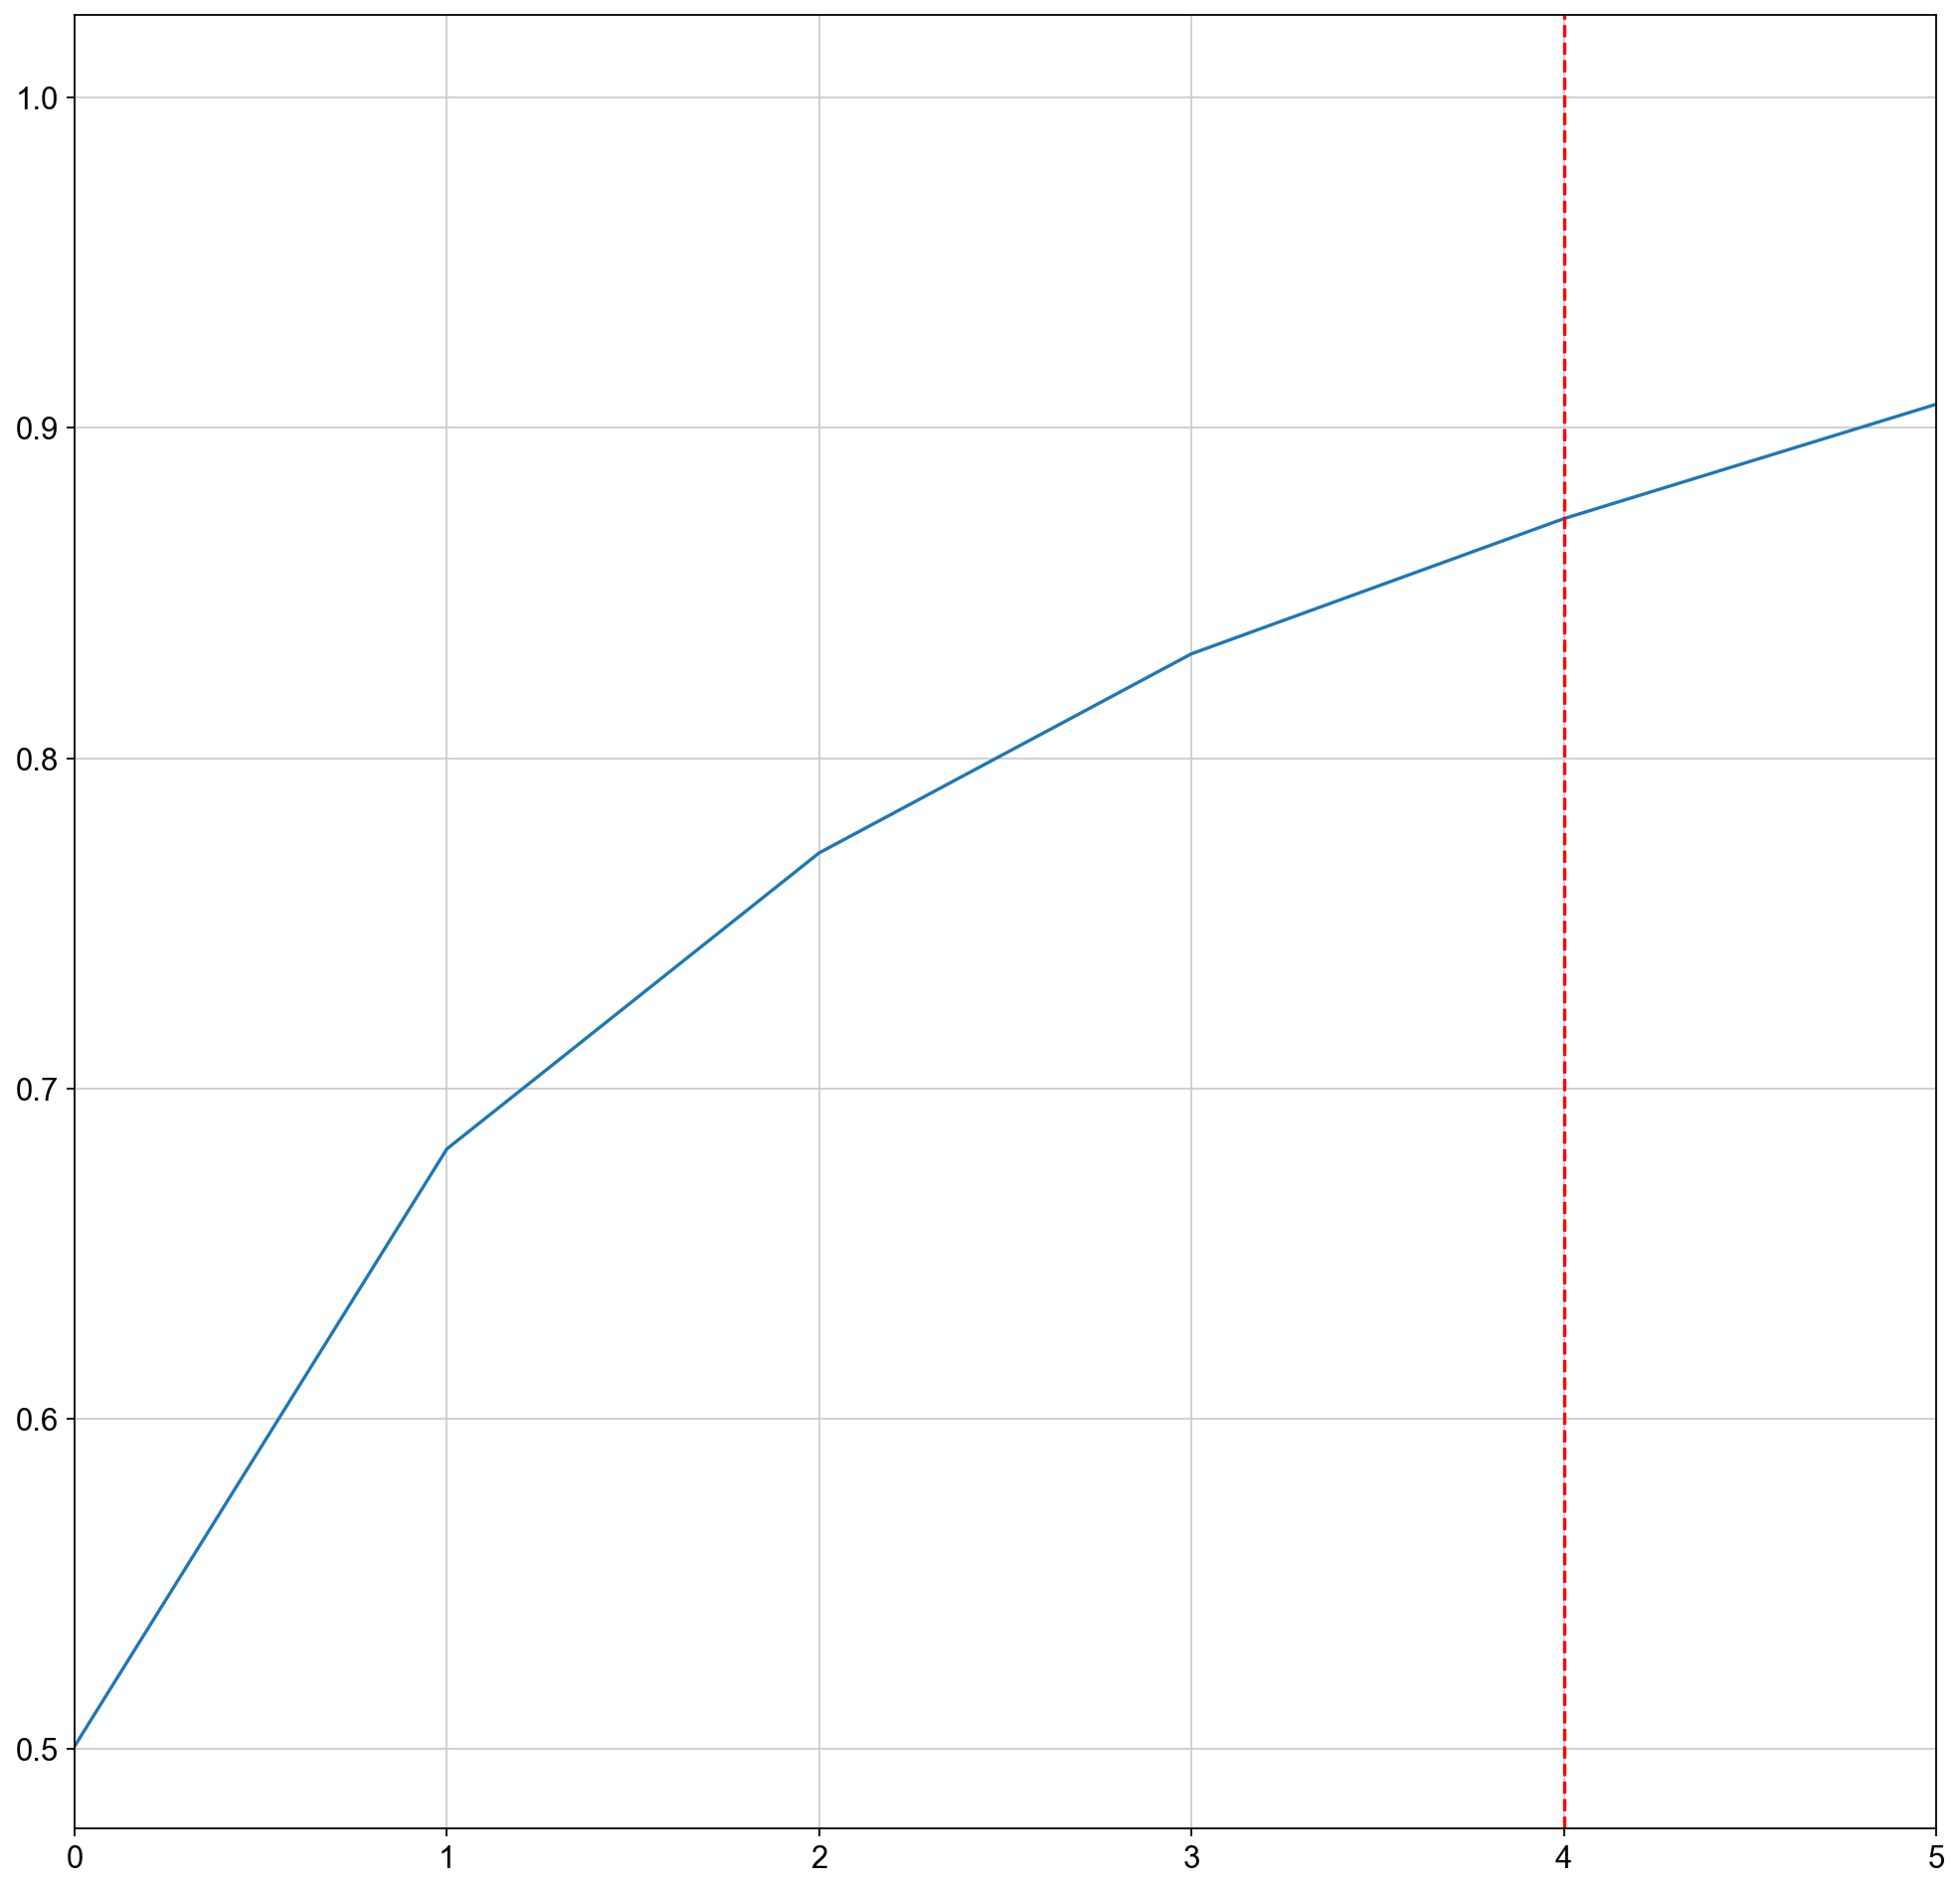

In [104]:
dimred = PCA()
dimred.fit(xenium_overlap_scdata_filtered.X)
sns.lineplot(np.cumsum(dimred.explained_variance_ratio_))
location = KneeLocator(range(1, len(dimred.explained_variance_ratio_) + 1),
                       np.cumsum(dimred.explained_variance_ratio_),
                       curve="concave", direction="increasing")
plt.axvline(location.elbow, color="red", linestyle="--")
plt.xlim((0, 5));

In [105]:
sc.pp.pca(xenium_overlap_scdata_filtered, n_comps = 4)

In [ ]:
umap_operator = umap.UMAP(n_components = 2, random_state = 42)
umap_result_xenium = umap_operator.fit_transform(xenium_overlap_scdata_filtered.obsm['X_pca'])

In [ ]:
xenium_overlap_scdata_filtered.obsm['X_umap'] = umap_result_xenium

In [ ]:
sc.pp.neighbors(xenium_overlap_scdata_filtered, use_rep = 'X_umap', n_neighbors=20)

In [ ]:
sc.tl.leiden(xenium_overlap_scdata_filtered, resolution = 0.01)

In [ ]:
sc.pl.umap(xenium_overlap_scdata_filtered, color = 'leiden')

### Cosmx Overlap

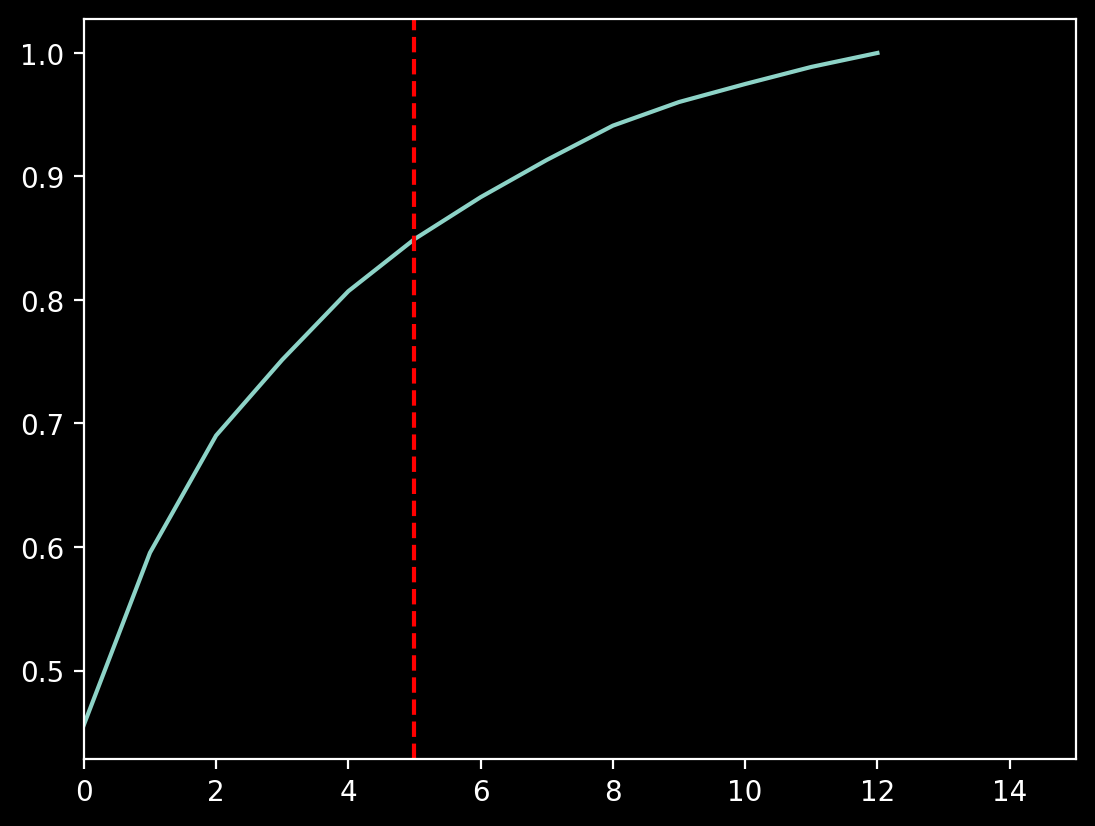

In [68]:
dimred = PCA()
dimred.fit(cosmx_overlap_scdata_filtered.X)
sns.lineplot(np.cumsum(dimred.explained_variance_ratio_))
location = KneeLocator(range(1, len(dimred.explained_variance_ratio_) + 1),
                       np.cumsum(dimred.explained_variance_ratio_),
                       curve="concave", direction="increasing")
plt.axvline(location.elbow, color="red", linestyle="--")
plt.xlim((0, 15));

In [69]:
sc.pp.log1p(cosmx_overlap_scdata_filtered)
sc.pp.normalize_total(cosmx_overlap_scdata_filtered)
sc.pp.scale(cosmx_overlap_scdata_filtered)
sc.pp.pca(cosmx_overlap_scdata_filtered, n_comps = 5, random_state = 42)
umap_operator = umap.UMAP(n_components = 2, random_state = 42, metric = 'euclidean', min_dist = 0.01, n_neighbors = 40)
umap_result_cosmx = umap_operator.fit_transform(cosmx_overlap_scdata_filtered.X)
cosmx_overlap_scdata_filtered.obsm['X_umap'] = umap_result_cosmx

C:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\preprocessing\_simple.py:372: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
C:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [70]:
sc.pp.neighbors(cosmx_overlap_scdata_filtered, use_rep = 'X_umap', n_neighbors = 40)

In [71]:
sc.tl.leiden(cosmx_overlap_scdata_filtered, resolution = 0.001)

C:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


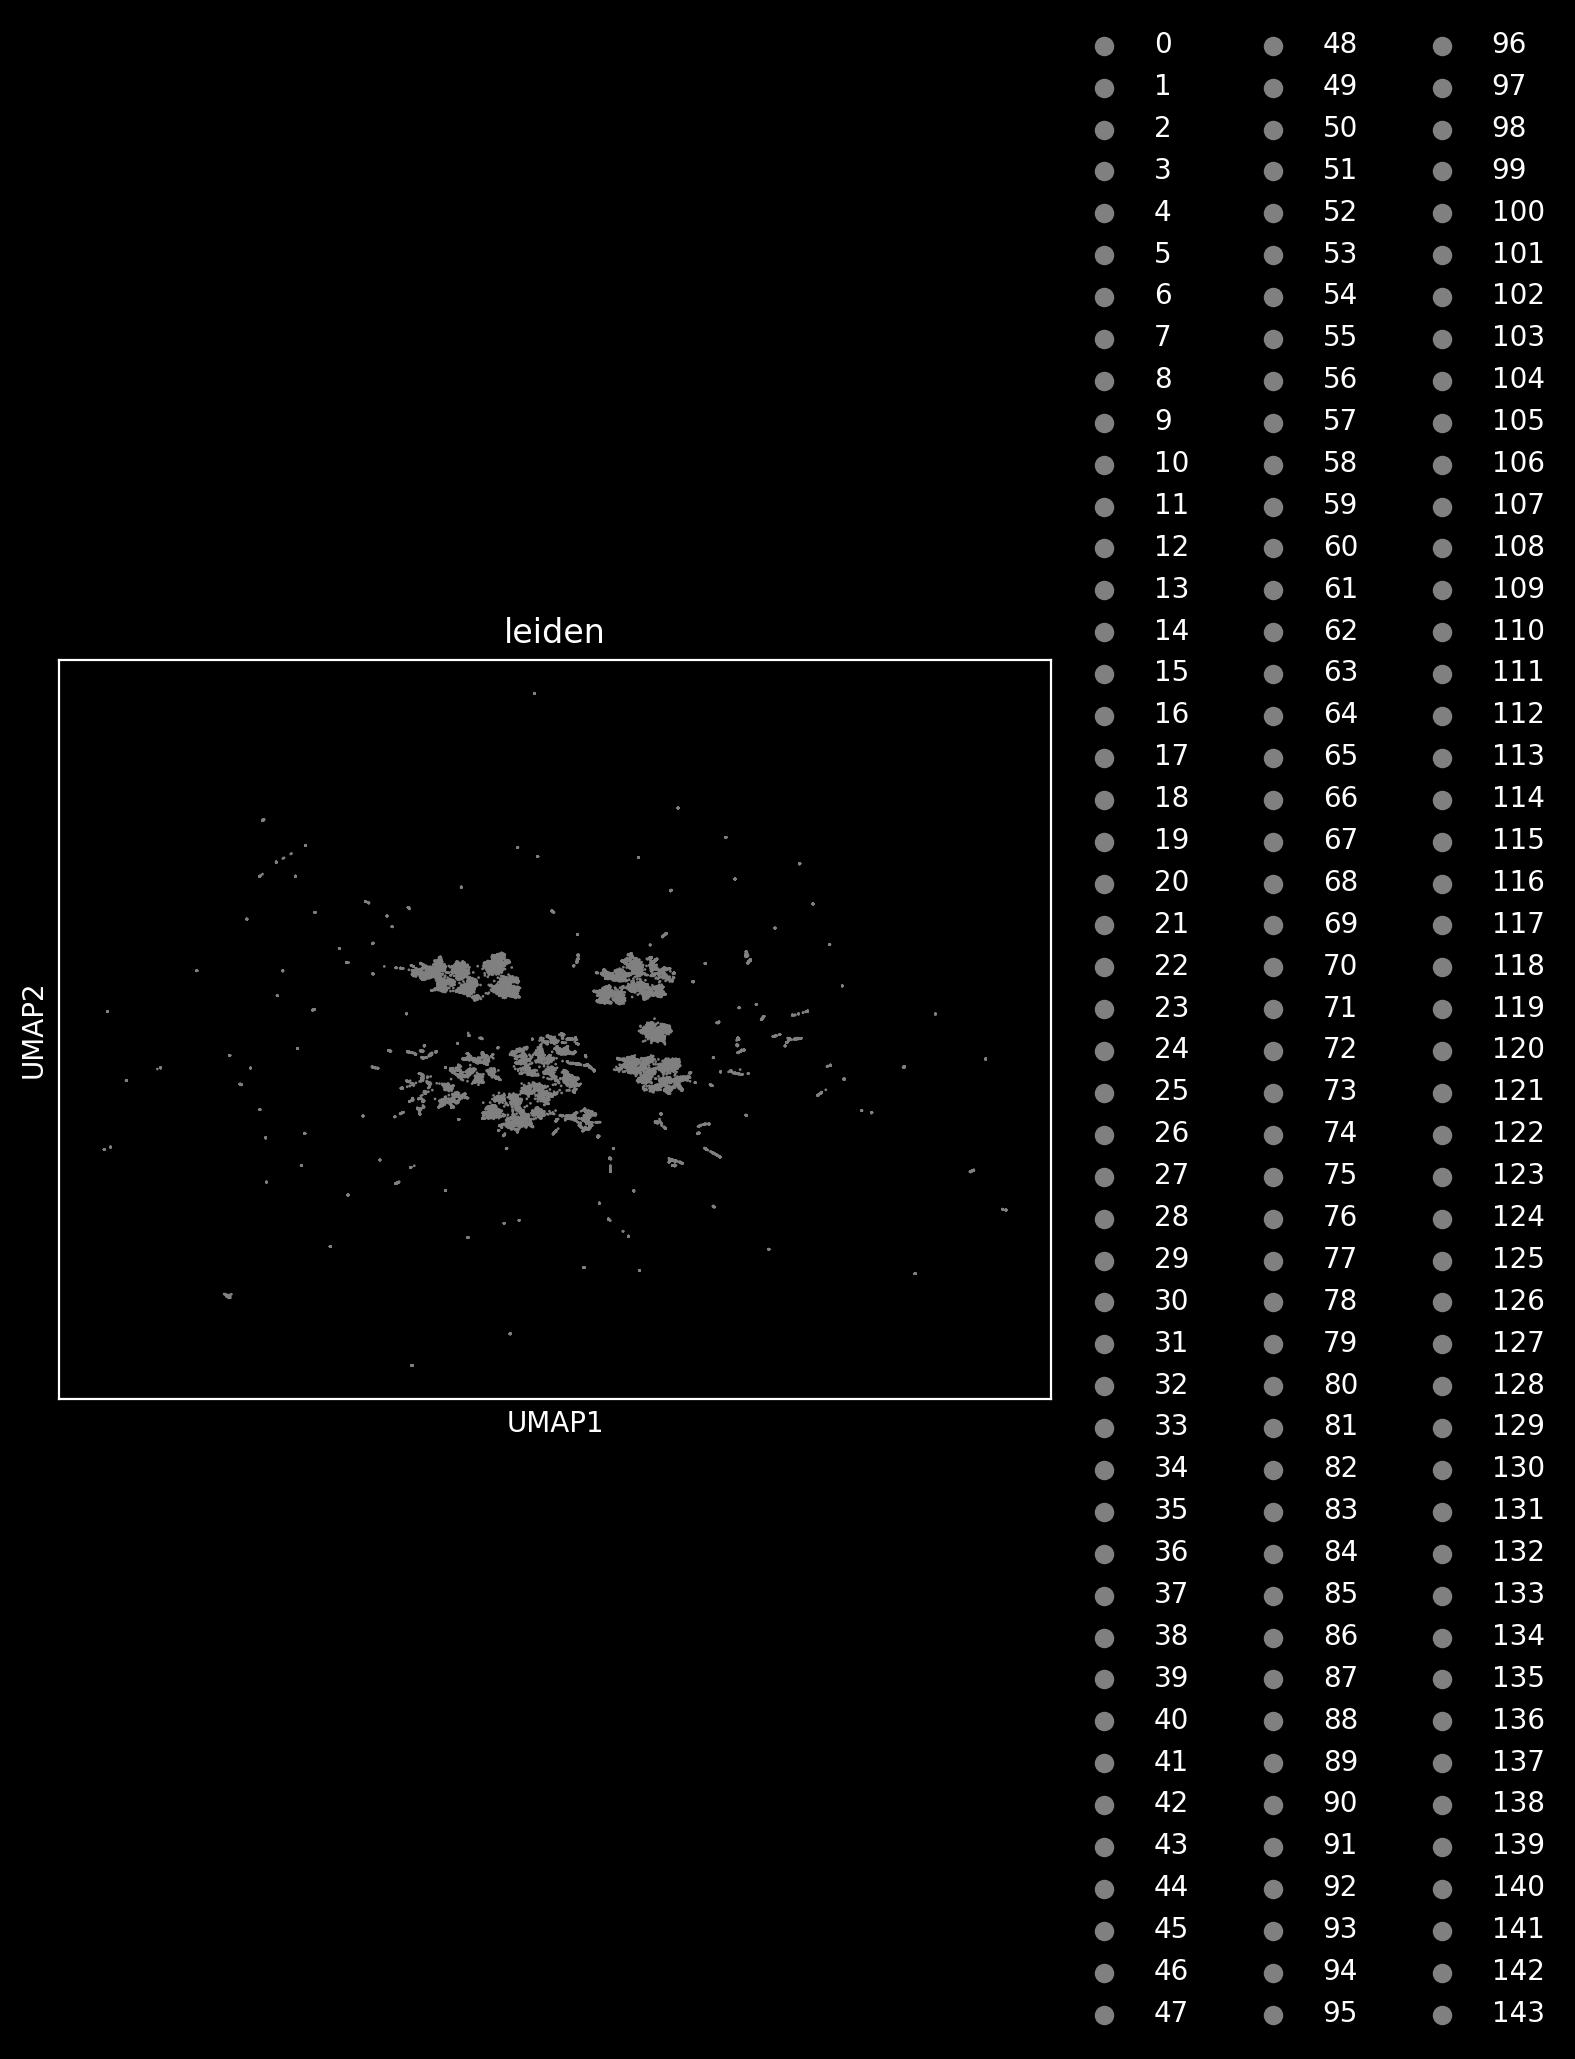

In [76]:
sc.pl.umap(cosmx_overlap_scdata_filtered, color = 'leiden')

In [97]:
cosmx_leiden_to_keep = list(cosmx_overlap_scdata_filtered.obs['leiden'].value_counts()[cosmx_overlap_scdata_filtered.obs['leiden'].value_counts() >= 100].index)
cosmx_leiden_to_keep

['0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15']

In [98]:
cosmx_overlap_scdata_filtered_leiden = cosmx_overlap_scdata_filtered[np.isin(cosmx_overlap_scdata_filtered.obs['leiden'], cosmx_leiden_to_keep)]
cosmx_overlap_scdata_filtered_leiden

View of AnnData object with n_obs × n_vars = 27912 × 13
    obs: 'total_counts', 'leiden', 'celltype', 'gene_count'
    var: 'mean', 'std'
    uns: 'celltype_colors', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_raw', 'X_spatial', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

C:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


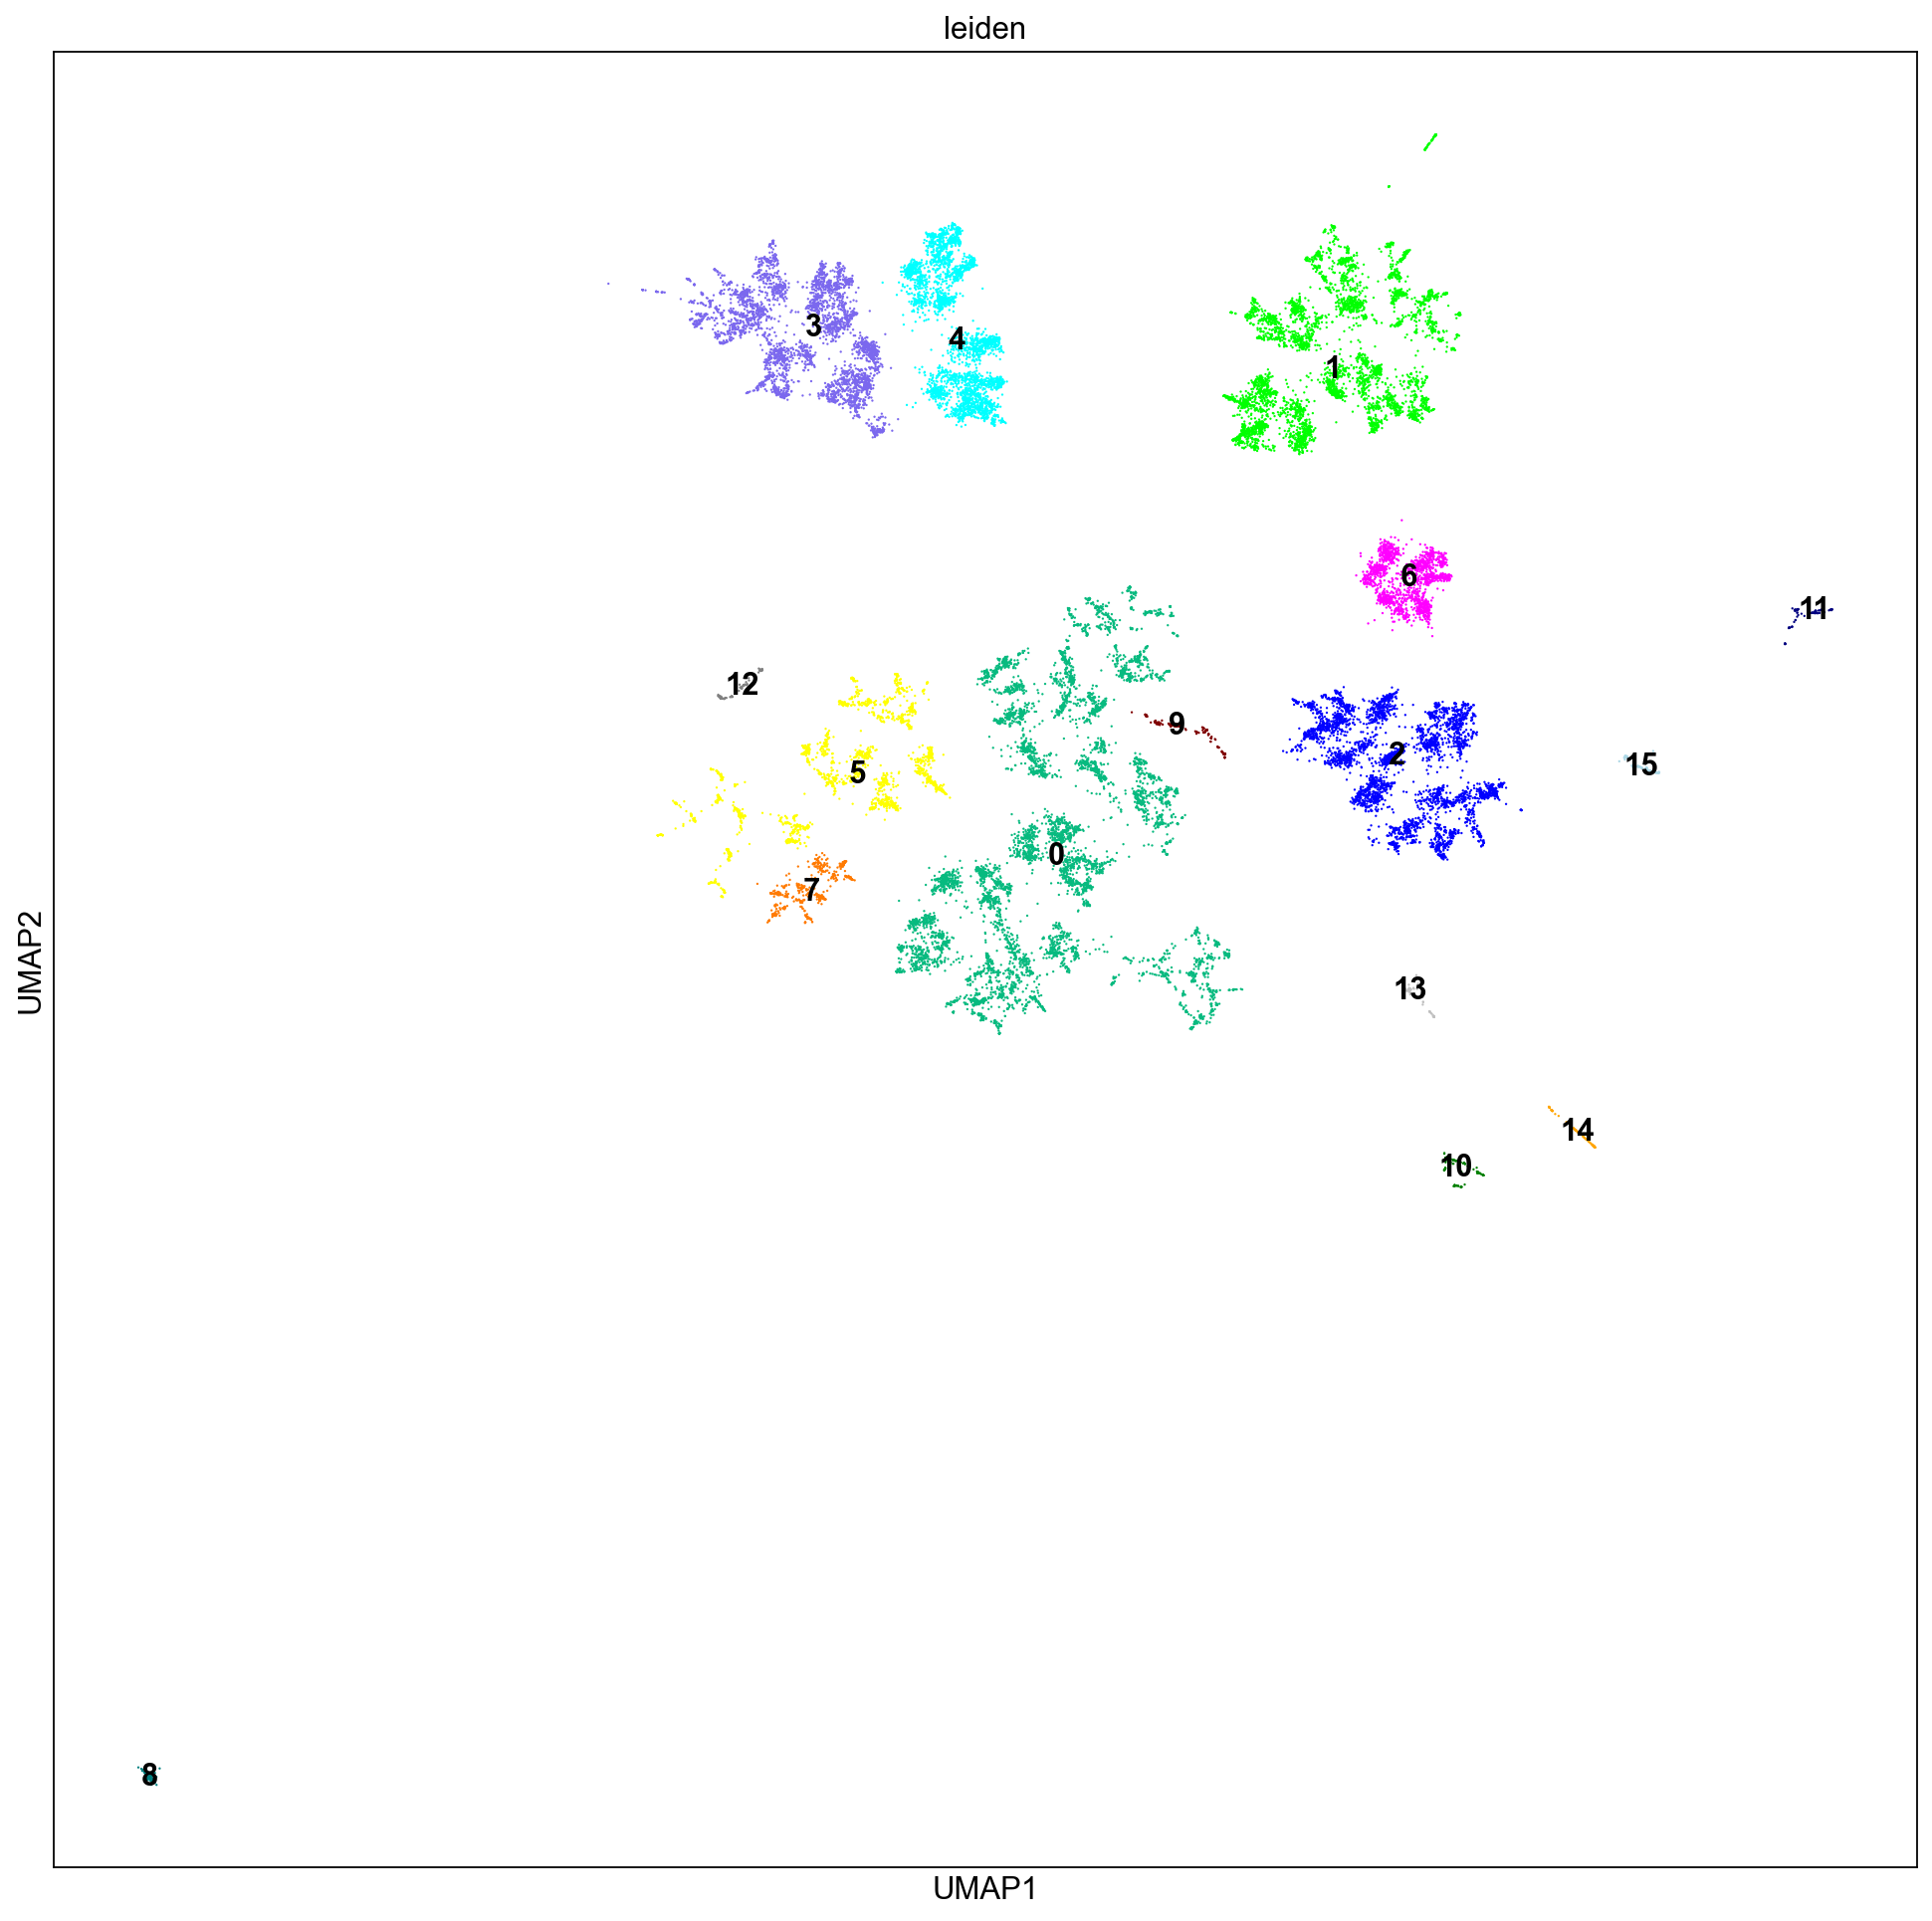

In [102]:
sc.pl.umap(cosmx_overlap_scdata_filtered_leiden, color = 'leiden', legend_loc = 'on data')

In [100]:
adata_cosmx_overlap = Jenie(cosmx_overlap_scdata_filtered_leiden, 'cosmx_overlap_scdata_filtered_leiden', 'cosmx_overlap_scdata_filtered_leiden', pallete = 'color_dict')

C:\Users\krist\Cleveland Lab Group\activation_of_quiescent_neurogenic_niches_of_aging_brain\Class\jenie.py:1007: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.data.obs["x"] = "x"
C:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:371: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
C:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:381: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
C:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_too

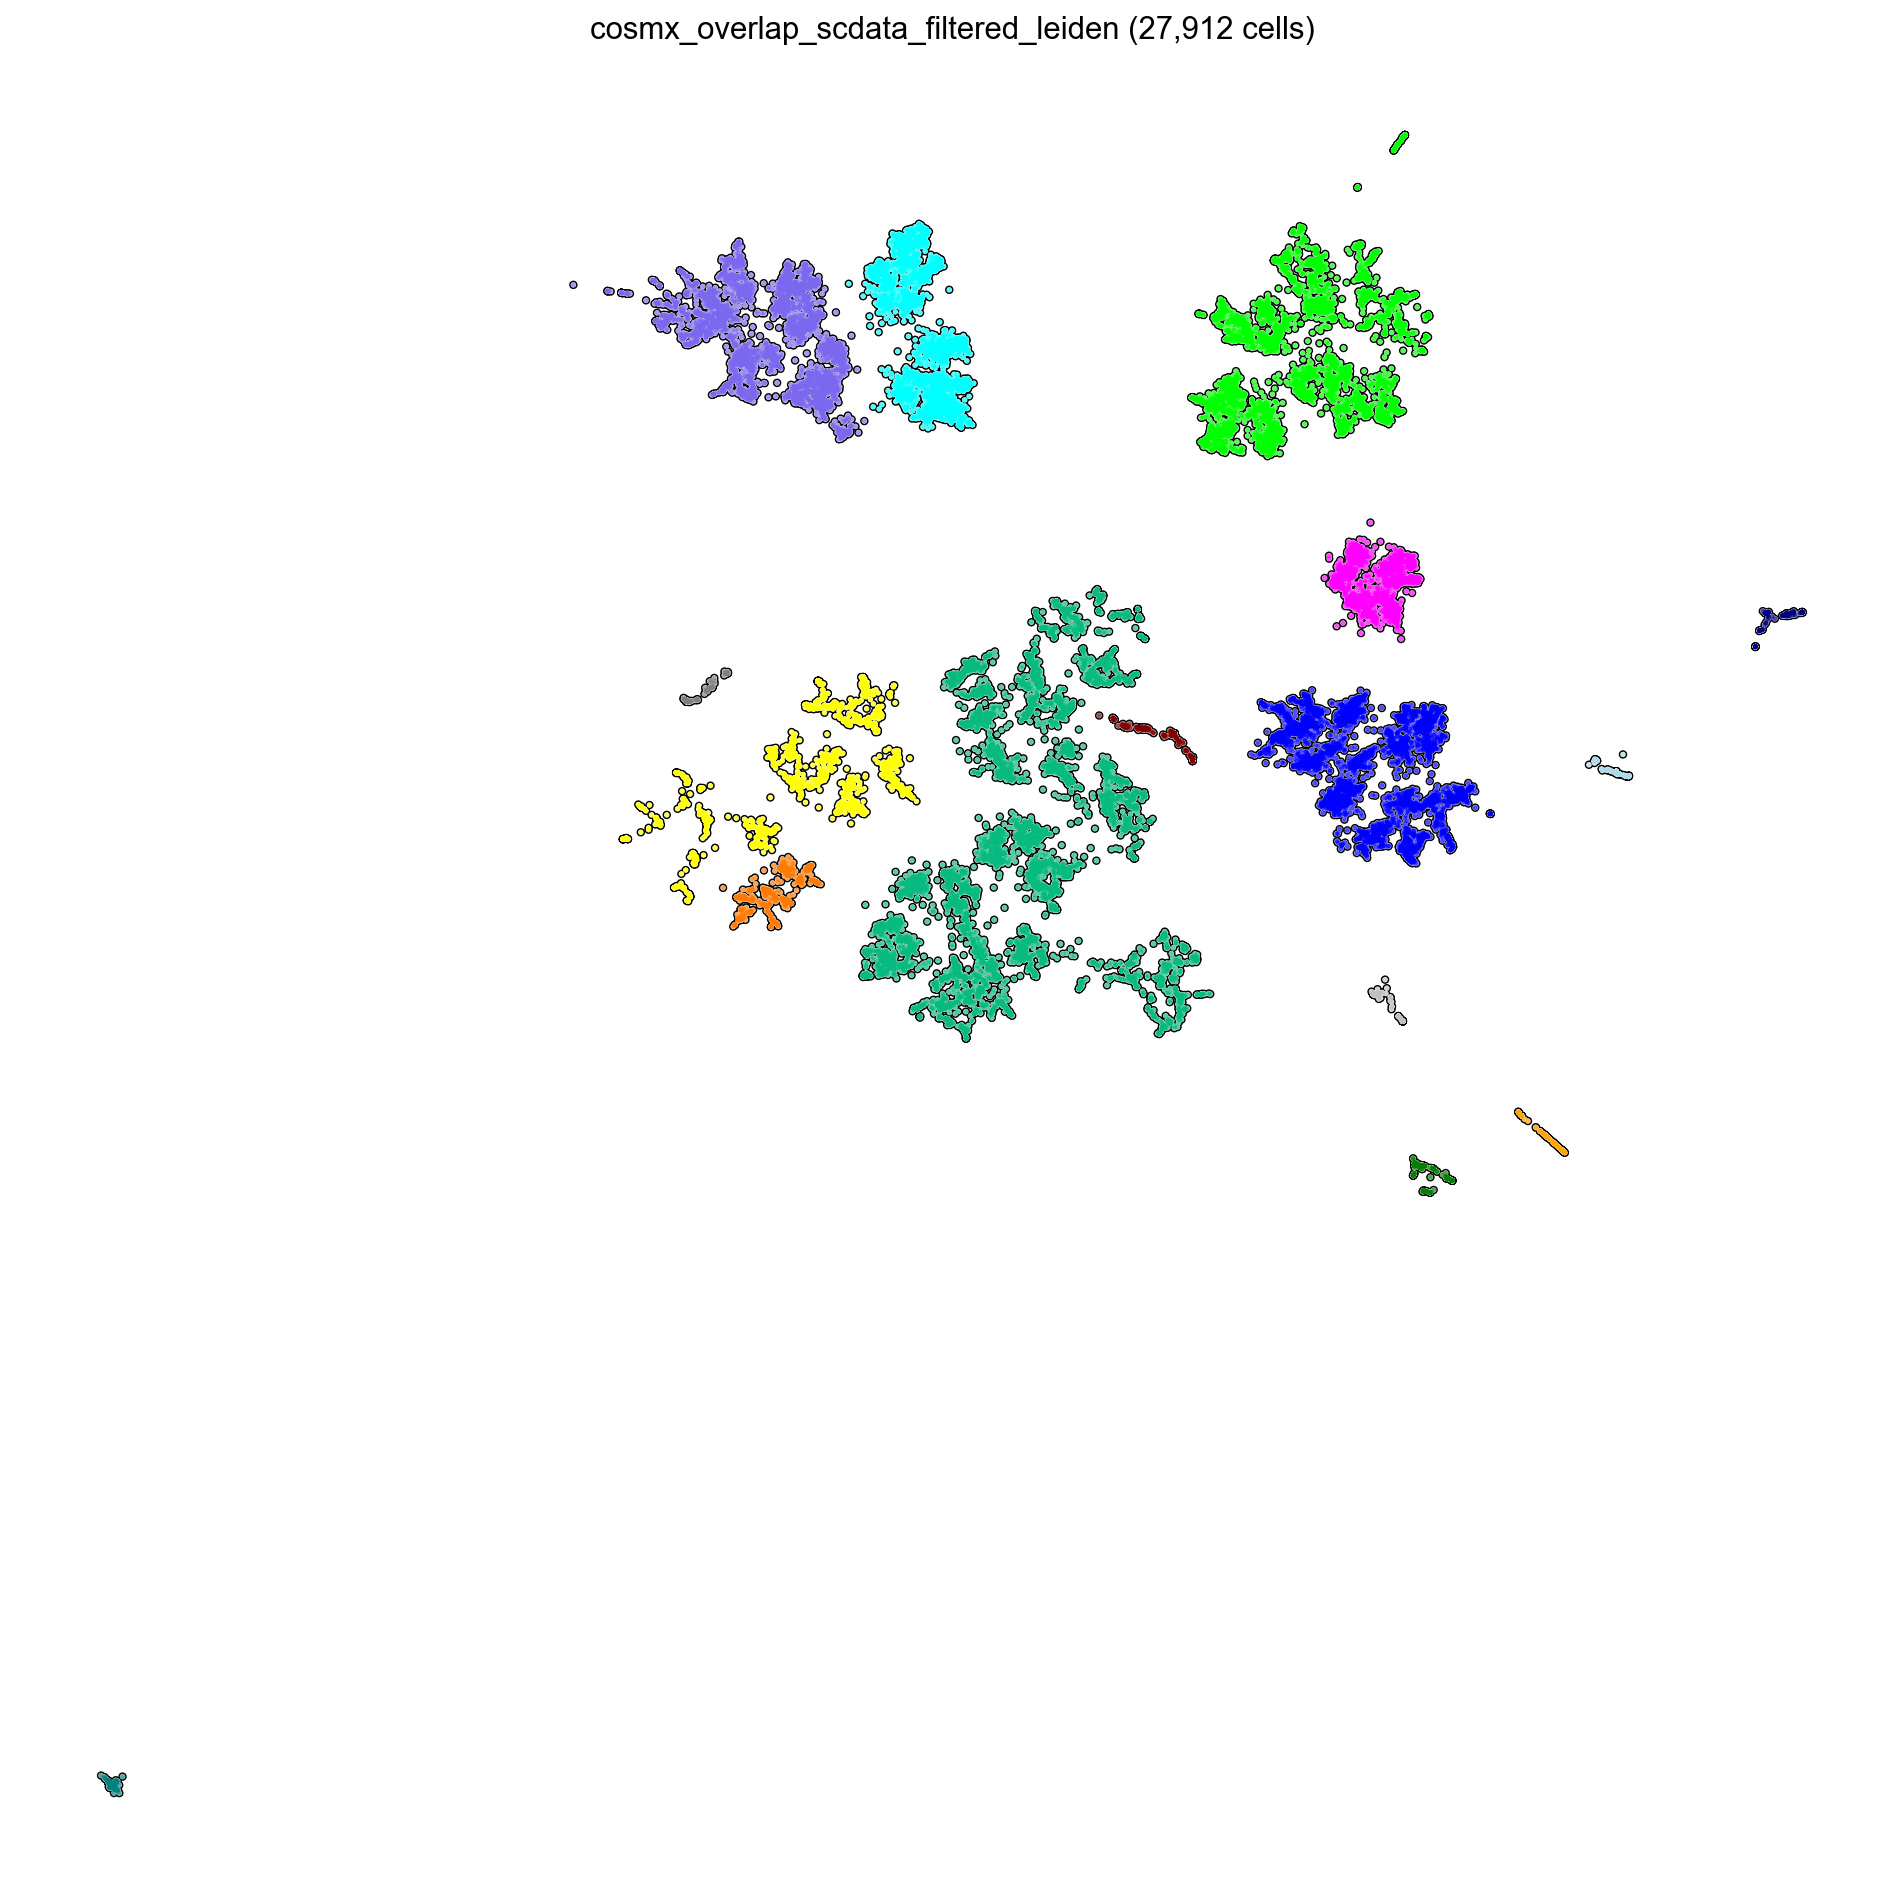

In [101]:
adata_cosmx_overlap.umap(group = 'leiden')

### Gellyfish Overlap

In [ ]:
sc.pp.neighbors(gellyfish_overlap_scdata)
sc.tl.leiden(gellyfish_overlap_scdata)
sc.pl.umap(gellyfish_overlap_scdata, color = 'leiden')